# Classification - Bank Marketing

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Go through this - https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
import tensorflow as tf
import os
import tempfile

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


# For visualisations
shap.initjs()

In [2]:
# Import data from csv
csv_file = 'data/classification-bank/bank-full.csv'
dataframe = pd.read_csv(csv_file, index_col=False, sep=';')

In [3]:
# Add a random column to use to compare to more meaningful columns
dataframe['noise'] = np.random.randint(0,5, size=len(dataframe))

In [4]:
# Convert the Y value to 1 or 0
dataframe['y_binary'] = np.where(dataframe['y']=='yes', 1, 0)
dataframe.drop(['y'], axis=1, inplace=True)

In [5]:
# Drop non-numerical values (fow now)
dataframe.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'pdays', 'poutcome'], axis=1, inplace=True)
dataframe.head()

,age,balance,campaign,previous,noise,y_binary
0,58,2143,1,0,1,0
1,44,29,1,0,4,0
2,33,2,1,0,3,0
3,47,1506,1,0,0,0
4,33,1,1,0,3,0


In [6]:
# Split data (note this randomises the split so no stratification issues)
train_df, test_df = train_test_split(dataframe, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df.head()

,age,balance,campaign,previous,noise,y_binary
19263,46,765,2,0,0,0
28385,39,1099,2,6,0,0
27647,38,6742,2,0,4,0
3597,43,1195,9,0,0,0
5239,31,360,1,0,0,0


In [7]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('y_binary'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('y_binary'))
test_labels = np.array(test_df.pop('y_binary'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(len(bool_train_labels))

28934


In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (28934,)
Validation labels shape: (7234,)
Test labels shape: (9043,)
Training features shape: (28934, 5)
Validation features shape: (7234, 5)
Test features shape: (9043, 5)


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0.98, 'Negative distribution')

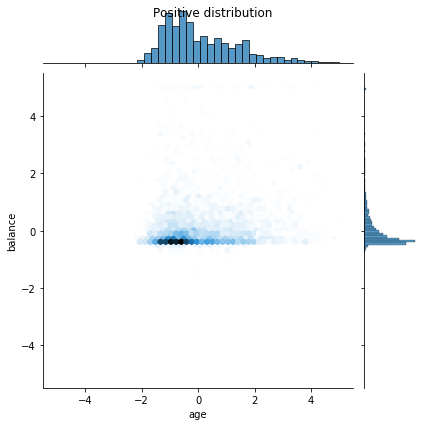

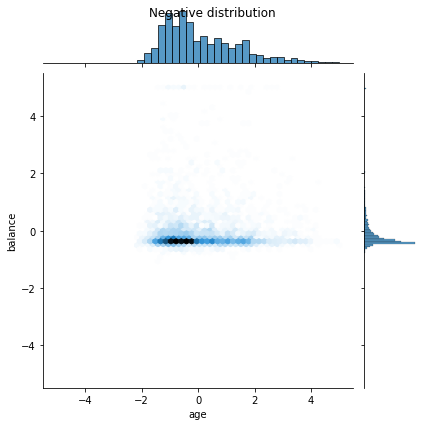

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)


sns.jointplot(pos_df['age'], pos_df['balance'],
              kind='hex', xlim=(-5.5,5.5), ylim=(-5.5,5.5))
plt.suptitle("Positive distribution")

sns.jointplot(pos_df['age'], neg_df['balance'],
              kind='hex', xlim=(-5.5,5.5), ylim=(-5.5,5.5))
plt.suptitle("Negative distribution")


In [10]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [11]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


In [12]:
EPOCHS = 100
BATCH_SIZE = 2048
model = make_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Test run model as a sanity check
model.predict(train_features[:10])

array([[0.33588296],
       [0.27434105],
       [0.15981182],
       [0.37662095],
       [0.25440425],
       [0.2515006 ],
       [0.25800842],
       [0.25632352],
       [0.2325474 ],
       [0.24316198]], dtype=float32)

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4276


In [15]:
pos = pos_df.shape[0]
neg = neg_df.shape[0]
initial_bias = np.log([pos/neg])
initial_bias

array([-2.01857052])

In [16]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])


array([[0.07711884],
       [0.09993881],
       [0.14523801],
       [0.0425438 ],
       [0.03387344],
       [0.0584057 ],
       [0.10294577],
       [0.12254947],
       [0.13033107],
       [0.12984404]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.3680


In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


In [19]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

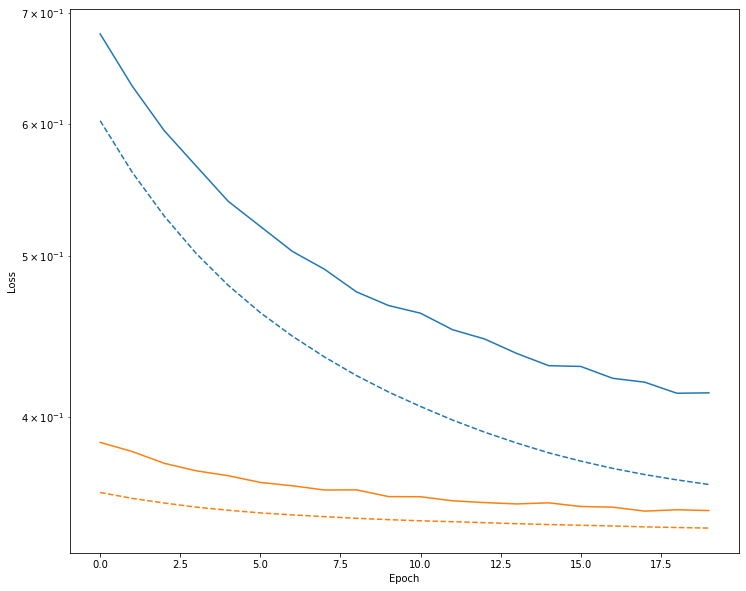

In [28]:
plot_loss(zero_bias_history, "Zero Bias", 0) # blue
plot_loss(careful_bias_history, "Careful Bias", 1) # orange

In [30]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels))

Epoch 1/100
15/15 [==============================] - 4s 149ms/step - loss: 0.3828 - tp: 40.5625 - fp: 93.6250 - tn: 21374.0625 - fn: 2782.5000 - accuracy: 0.8822 - precision: 0.3278 - recall: 0.0136 - auc: 0.5655 - prc: 0.1546 - val_loss: 0.3601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6403.0000 - val_fn: 831.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5572 - val_prc: 0.1366
Epoch 2/100
15/15 [==============================] - 1s 71ms/step - loss: 0.3787 - tp: 36.3750 - fp: 73.8750 - tn: 14986.6250 - fn: 1959.8750 - accuracy: 0.8813 - precision: 0.3543 - recall: 0.0198 - auc: 0.5307 - prc: 0.1475 - val_loss: 0.3571 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6403.0000 - val_fn: 831.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5708 - val_prc: 0.1441
Epoch 3/100
15/15 [==============================] - 1s 58ms/step - loss: 0.3749 - tp: 40.3125 - fp: 89.8125 - tn: 14967.31

In [31]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


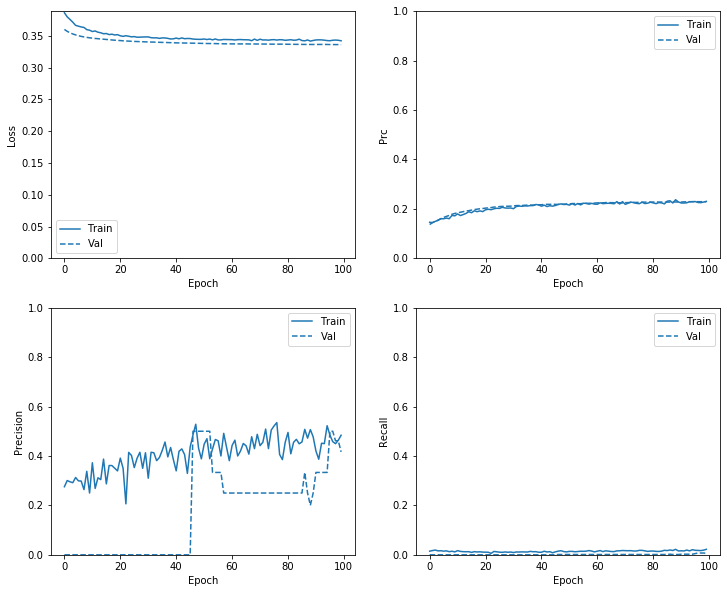

In [33]:
plot_metrics(baseline_history)


In [24]:
# Evaluate the overall accuracy of our model using the test set
loss, accuracy = model.evaluate(test_ds)
print("Test set accuracy", accuracy)

# Calculate percentage of y=0 values for comparison
y_zero = test_df['y_binary'].value_counts()[0]
y_one = test_df['y_binary'].value_counts()[1]
print(y_zero / (y_zero + y_one))

NameError: name 'test_ds' is not defined

In [ ]:
# Select an index value to predict/explain
index_to_explain = 388

In [ ]:
# Takes an array of numpy arrays representing X values (this is format required by SHAP)
def predict_wrapper(sample, col_indexes):
    data_for_tensor = {}
    for name, index in col_indexes.items():
        values = []
        for val in sample:
            values.append(val[index])
        data_for_tensor[name] = values
    input_tensor = {name: tf.convert_to_tensor(value) for name, value in data_for_tensor.items()}
    return model.predict(input_tensor)

# Tells our predictor which columns our numpy array values correspond to
def bank_marketing_wrapper(sample):
    column_mappings = {
        'age': 0,
        'job': 1,
        'marital': 2,
        'education': 3,
        'default': 4,
        'balance': 5,
        'housing': 6,
        'loan': 7,
        'campaign': 12
    }
    return predict_wrapper(sample, column_mappings)

# Allows us to predict a value for a specific dataframe index
def predict_from_df(df, index):
    return bank_marketing_wrapper([df.iloc[index,:].to_numpy()])

In [ ]:
predict_from_df(dataframe, index_to_explain)

In [ ]:
%%time
num_reference_values = 50
num_perturbations = 500

# Instances passed to second param of KernalExplainer constructor are used to calculate reference values
# nsamples is how many times we perturb around a specific instance to get the explanation (shap values)

# This never takes significant time - just calculating background values
explainer = shap.KernelExplainer(bank_marketing_wrapper, dataframe.iloc[:num_reference_values,:])

# Running time is O(num_reference_values * num_perturbations)
shap_values = explainer.shap_values(dataframe.iloc[index_to_explain,:], nsamples=num_perturbations)
with np.printoptions(precision=2, suppress=True):
    print(shap_values)
# shap.force_plot(explainer.expected_value, shap_values[0], dataframe.iloc[index_to_explain,:])

print(np.linalg.norm(np.array(perturbed_shap_values) - np.array(shap_values)))

In [ ]:
# Naive implementation of sensitivity metric

# (Categorical values could be difficult with current use of feature columns - maybe worth changing this)?
# Also - this doens't really work at all as we need to apply perturbations to normalised values


# Set the perturbation radius (L2)
r = 5

# Set the number of perturbations to make and loop
num_perturbations_sen = 20

# Keep track of the maximum explanation difference
max_difference = 0

for index in range(num_perturbations_sen):
    # Randomly decide how many features to perturb
    n = random.randrange(1, len(feature_columns) + 1)

    # Calculate the required perturbation value to stay within r (radius)
    p = (r ** 2) / n

    # Randomly decide which features to peturb
    features_to_perturb = random.sample(feature_columns, n)
    
    # Make a copy of the instance
    instance_copy = dataframe.iloc[index_to_explain,:].copy(deep=True)
    # Apply the perturbations, randomly choosing direction
    for feature in features_to_perturb:
        direction = random.randrange(2)
        if direction == 0:
            instance_copy[feature.key] -= p
        else:
            instance_copy[feature.key] += p
        
    perturbed_shap_values = explainer.shap_values(instance_copy, nsamples=num_perturbations)
    
    # Calculate L2 distance between this and the original explanation
    difference = np.linalg.norm(np.array(perturbed_shap_values) - np.array(shap_values))
    
    if difference > max_difference:
        max_difference = difference
        
print(max_difference)

In [ ]:
# Naive implementation of fidelity metric
# Let's say, for example, our perturbation of interest is setting 'balance' to zero

# Perturbation (dot) explanation without perturbation


In [ ]:
# Transposes and dot products

# MNo

a = [1,2,3]
b = [4,5,6]

np.dot(a, b)